In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from ssm.util import random_rotation
from ssm.util import softplus

In [3]:
import ssm
ssm.__file__

'/Users/scott/Projects/josh_ssm/ssm/__init__.py'

### Set variables

In [4]:
D_vec=[2,2]
N_vec=[10,10]

t_end=70
num_trials=5
D=np.sum(D_vec)

In [5]:
np.random.seed(10)

alpha=.1

A0=np.zeros([4,4])
A0[0,1:]=alpha*np.random.randn(3)
A0[1,2:]=alpha*np.random.randn(2)
A0[2,3:]=alpha*np.random.randn(1)

In [6]:
A1=A0-A0.T+np.identity(4) #.97

In [7]:
eigs=np.linalg.eigvals(A1)

In [8]:
div=np.max(np.abs(eigs))

In [9]:
A=A1/div

In [10]:
# np.linalg.eigvals(A1)

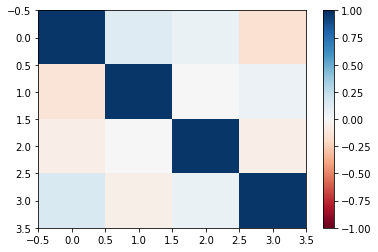

In [11]:
plt.imshow(A, aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()

In [12]:
np.linalg.eigvals(A)

array([0.97494239+0.22245748j, 0.97494239-0.22245748j,
       0.97494239+0.05940572j, 0.97494239-0.05940572j])

In [13]:
np.sqrt(.975**2+.222**2)

0.9999544989648279

In [14]:
C=np.zeros([np.sum(N_vec),np.sum(D_vec)])
np.random.seed(1)
C[:N_vec[0],:D_vec[0]]=np.random.randn(1,N_vec[0],D_vec[0])
np.random.seed(2)
C[N_vec[0]:,D_vec[0]:]=np.random.randn(1,N_vec[1],D_vec[1])


# C11=np.arange(0,80)-40
# C12=np.arange(0,80)
# C21=np.arange(0,40)-20
# C22=np.arange(0,40)

# C=np.zeros([120,4])
# C[80:,0]=1
# C[80:100,1]=1
# C[100:120,1]=-1

# C[:80,2]=1
# C[:40,3]=1
# C[40:80,3]=-1

C=C/np.sqrt(np.sum(C**2,axis=0))


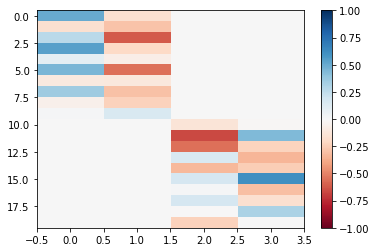

In [15]:
plt.imshow(C, aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
plt.colorbar()

In [16]:
# Cprime=np.dot(C,A)

In [17]:
# plt.imshow(Cprime, aspect='auto', interpolation="none", vmin=-1, vmax=1, cmap='RdBu')
# plt.colorbar()

In [18]:
# C=np.zeros([120,4])
# C[80:,:2]=np.random.randn(1,40,2)
# C[:80,2:]=np.random.randn(1,80,2)
# C=C/np.sqrt(np.sum(C**2,axis=0))

# np.dot(C[80:,0],C[80:,1])

In [19]:
np.random.seed(3)
xs=[]
ys=[]
inputs=[]
for tr in range(num_trials):
    x=np.zeros([np.sum(D_vec),t_end])
    x[:,0]=np.array([-80, -30, 20, 70])+20*np.random.randn(np.sum(D_vec))
    #120*np.random.randn(np.sum(D_vec)) #[.5,-.5,.5,-.5]
    # for i in range(4):
    #     for t in range(t_end-1):
    #         x[i,t+1]=x[i,t]+np.random.randn()
    e1=3 #was 6
    for t in range(t_end-1):
        x[:,t+1]=np.dot(A,x[:,t])+e1*np.random.randn(np.sum(D_vec))
        
    e=5 #was 10
    noise=e*np.random.randn(np.sum(N_vec),t_end)
    lam=softplus(np.dot(C,x)+noise)
    y=np.random.poisson(lam)
    
    input_tr=np.random.randn(2,t_end)
    
    xs.append(x)
    ys.append(y)
    inputs.append(input_tr.T)

In [20]:
# from sklearn import linear_model
# reg=linear_model.LinearRegression()
# x_temp=np.concatenate((x[2:3,:],x[3:4,:]),axis=0)
# # x_temp=np.copy(x[1:2,:])
# y_temp=x[0:1,:]
# reg.fit(x_temp.T,y_temp.T)
# # reg.fit(x[0:1,:].T,x[3:4,:].T)
# plt.plot(reg.predict(x_temp.T))
# plt.plot(y_temp.T)

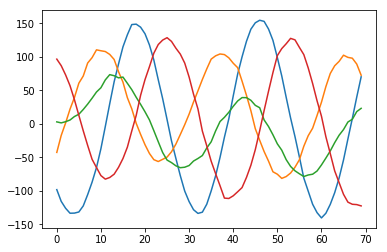

In [21]:
plt.plot(x.T)
# plt.ylim([-.1, .1])

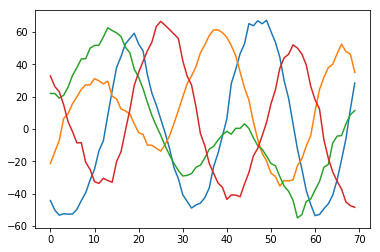

In [22]:
plt.plot(xs[0][0,:])
plt.plot(xs[0][1,:])
plt.plot(xs[0][2,:])
plt.plot(xs[0][3,:])
# plt.ylim([-.1,.1])

# LDS

In [23]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.models import LDS
from ssm.models import SLDS
from ssm.util import random_rotation, find_permutation

In [24]:
masks=[]
y_masks=[]
# Mask off some data
npr.seed(20)
for t in range(num_trials):
    mask = npr.rand(np.sum(N_vec), t_end) < 0.8
    masks.append(mask.T)
    y_masks.append((ys[t]*mask).T)

## Unconstrained

In [25]:
# lds = LDS(N=np.sum(N_vec),D=np.sum(D_vec),emissions="poisson_constrained", emission_kwargs=dict(link="softplus"),kwargs=dict(N_vec=N_vec))
# lds = LDS(N=np.sum(N_vec),D=np.sum(D_vec),emissions="poisson_constrained", emission_kwargs=dict(link="softplus",N_vec=np.sum(N_vec),D_vec=np.sum(D_vec))) 
lds = LDS(N=np.sum(N_vec),D=np.sum(D_vec),emissions="poisson_constrained", emission_kwargs=dict(link="softplus",N_vec=N_vec,D_vec=D_vec)) 


In [26]:
# stop

In [27]:
lds.initialize(y_masks, masks=masks)
# q = SLDSTriDiagVariationalPosterior(lds, y, masks=masks, initial_variance=1)
q = SLDSMeanFieldVariationalPosterior(lds, y_masks, masks=masks, initial_variance=1)
elbos = lds.fit(q, y_masks, masks=masks, num_iters=400, print_intvl=100, initialize=False)
lds_x = q.mean[0]

Initializing with an ARHMM using 25 steps of EM.


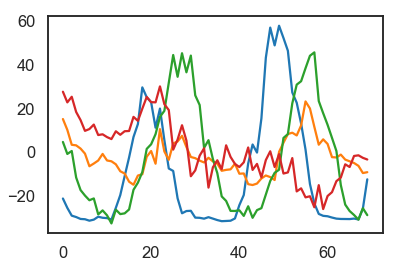

In [29]:
plt.plot(lds_x)

In [31]:
y_smooth = lds.smooth(q.mean[0], y_masks[0], mask=masks[0])

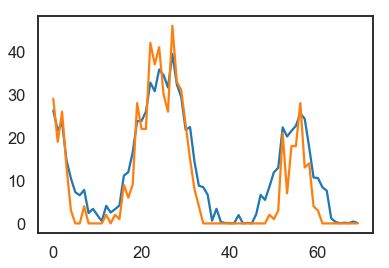

In [40]:
n = 15
plt.plot(y_smooth[:, n])
plt.plot(ys[0][n])